# Parallel Processing of Wine Review Data**

## Objective

Can we recreate this $5$ basic wine type groupings?

<p align="center">
<img src="images/Different-Types-of-Wine-v2.jpg"alt="wine types" width="300"><img>
</p>

## Define Wine Classifications

**Helper functions to classify wines into the $9$ basic styles and $5$ basic types**

In [8]:
from collections import namedtuple
import pandas as pd

WINE_STYLE = namedtuple('WINE_STYLE', ['name', 'varieties'])

# wine varieties by wine style
sparkling = WINE_STYLE('sparkling', ['Cava','Prosecco', 'Crémant','Champagne', 'Spumante', 'Sparkling Blend'])

light_white = WINE_STYLE('light_white',
                         ['Albariño','Aligoté','Assyrtiko','Chablis','Chasselas','Chenin Blanc','Cortese','Friulano','Sauvignon Vert','Garganega','Grenache Blanc','Muscadet','Melon','Picpoul de Pinet','Pinot Blanc','Pinot Grigio','Pinot Gris','Verdejo','Verdicchio','Xarel-lo',]\
                          + ['Erbaluce','Grüner Veltliner','Sancerre','Sauvignon Blanc','Vermentino','Vinho Verde']
                        )
full_white = WINE_STYLE('full_white', ['Chardonnay','Marsanna','Sémillon','Trebbiano','Viognier','White Rioja','Pecorino', 'White Blend'])
aromatic_white = WINE_STYLE('aromatic_white', ['Gewürztraminer','Müller-Thurgau','Moschofilero','Muscat','Muscat Blanc','Moscato','Riesling','Torrontés',])
rose = WINE_STYLE('rose', ['Rosé', 'Rose'])
light_red = WINE_STYLE('light_red', ['Schiava', 'Gamay', 'Pinot Noir','Counoise', 'St. Laurent','Cinsaut','Primitivo','Blaufränkisch','Barolo'])
medium_red = WINE_STYLE('medium_red', ['Grenache','Granacha','Valpolicella Blend','Bobal','Carménère','Carignan','Cabernet Franc','Mencía', 'Sangiovese','Negroamaro','Rhône-style Red Blend', 'Rhône/GSM Blend','Barbera','Merlot','Montepulciano','Zinfandel','Marquette','Chambourcin','Petite Pearl','Red Blend', 'Portuguese Red'])
full_red = WINE_STYLE('full_red', ['Tempranillo','Nebbiolo',"Nero d'Avola",'Aglianico','Malbec','Bordeaux Blend','Cabernet Sauvignon','Syrah','Shiraz','Priorat','Touriga Franca','Pinotage','Petit Verdot','Mourvèdre','Touriga Nacional','Petite Sirah','Sagrantino','Tannat','Bordeaux-style Red Blend'])
dessert = WINE_STYLE('dessert', ['Ice Wine','Late Harvest','Madeira','Malvasia','Sauternes','Sherry','Tokaji','Vin Santo','White Port','Port','Porto','Marsala','Noble Rot','Passito','Freisa'])

all_varieties = pd.Series(sparkling.varieties + light_white.varieties + full_white.varieties + aromatic_white.varieties + rose.varieties + light_red.varieties + medium_red.varieties + full_red.varieties + dessert.varieties)

# assign style
styles = [sparkling, light_white, full_white, aromatic_white, rose, light_red, medium_red, full_red, dessert]
to_style = lambda wine: next(map(lambda style: style.name, filter(lambda style: wine in style.varieties, styles)))
to_type = lambda wine: next(map(lambda style: style.name.split('_')[-1], filter(lambda style: wine in style.varieties, styles)))


**Verify that there are no repeated wines varieties in the styles**

In [9]:
# verify there are no variety duplicated in any of the style varietals
assert all_varieties[all_varieties.duplicated()].count() == 0

**Verify the Type & Style Helpers**

In [10]:
assert to_style('Pinot Noir') == 'light_red'
assert to_type('Pinot Noir') == 'red'
to_style('Pinot Noir'), to_type('Pinot Noir')

('light_red', 'red')

## Load Preprocessed Reviews

Libraries

In [11]:
import numpy as np
import time

from IPython.display import Markdown, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Source: Kaggle [Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

In [12]:
df = pd.read_parquet('data/wine/wine_review.parquet.gzip', columns=['title', 'description', 'variety', 'country', 'location', 'wine_style', 'type', 'classification'])
df.info()
df


<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   title           100538 non-null  object
 1   description     100538 non-null  object
 2   variety         100538 non-null  object
 3   country         100538 non-null  object
 4   location        100538 non-null  object
 5   wine_style      100538 non-null  object
 6   type            100538 non-null  object
 7   classification  100538 non-null  object
dtypes: object(8)
memory usage: 6.9+ MB


,title,description,variety,country,location,wine_style,type,classification
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",White Blend,Italy,Etna,light_white,white,Old World
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Portuguese Red,Portugal,Douro,medium_red,red,Old World
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,US,Oregon,light_white,white,New World
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Riesling,US,Michigan,aromatic_white,white,New World
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Pinot Noir,US,Oregon,light_red,red,New World
...,...,...,...,...,...,...,...,...
129966,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Notes of honeysuckle and cantaloupe sweeten th...,Riesling,Germany,Mosel,aromatic_white,white,Old World
129967,Citation 2004 Pinot Noir (Oregon),Citation is given as much as a decade of bottl...,Pinot Noir,US,Oregon,light_red,red,New World
129968,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Well-drained gravel soil gives this wine its c...,Gewürztraminer,France,Alsace,aromatic_white,white,Old World
129969,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),"A dry style of Pinot Gris, this is crisp with ...",Pinot Gris,France,Alsace,light_white,white,Old World


## Load Sentence Embeddings

In [14]:
# load tf-idf
embeddings = pd.read_parquet('data/wine/mpnet_embeddings.parquet.gzip')
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.036825,0.040504,-0.049127,0.012060,-0.017809,0.045190,-0.047158,0.027785,0.037616,0.005221,...,-0.018225,-0.022451,-0.030674,0.030395,-0.036411,0.075180,-0.021670,0.017032,-0.024503,-0.021728
1,0.015400,0.076190,-0.017931,0.004965,-0.076234,0.021419,-0.074819,0.003389,0.057341,-0.003475,...,-0.071278,0.033845,-0.002066,0.018129,-0.004691,0.028105,-0.042770,0.010317,0.063025,-0.026926
2,0.032447,0.012291,-0.034564,-0.020621,-0.048290,0.031377,-0.082451,0.022635,0.002647,0.024966,...,-0.126703,0.035472,0.029064,0.006745,-0.012355,0.030802,-0.012589,0.024286,0.023172,-0.017200
3,0.076041,0.044183,-0.017158,-0.041186,-0.030582,0.051051,-0.076459,0.011513,0.011916,0.014672,...,-0.063876,-0.010313,0.004829,0.009389,-0.011263,0.035524,-0.014419,0.030267,-0.036529,-0.043187
4,0.011352,0.057223,-0.023293,0.022438,-0.078027,0.046609,-0.085686,-0.006774,0.038266,-0.014280,...,-0.058865,0.031108,0.006709,0.020604,-0.017218,0.023554,-0.039825,0.021364,0.025454,-0.022300


### Feature Matrix

In [15]:
X = embeddings
X

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.036825,0.040504,-0.049127,0.012060,-0.017809,0.045190,-0.047158,0.027785,0.037616,0.005221,...,-0.018225,-0.022451,-0.030674,0.030395,-0.036411,0.075180,-0.021670,0.017032,-0.024503,-0.021728
1,0.015400,0.076190,-0.017931,0.004965,-0.076234,0.021419,-0.074819,0.003389,0.057341,-0.003475,...,-0.071278,0.033845,-0.002066,0.018129,-0.004691,0.028105,-0.042770,0.010317,0.063025,-0.026926
2,0.032447,0.012291,-0.034564,-0.020621,-0.048290,0.031377,-0.082451,0.022635,0.002647,0.024966,...,-0.126703,0.035472,0.029064,0.006745,-0.012355,0.030802,-0.012589,0.024286,0.023172,-0.017200
3,0.076041,0.044183,-0.017158,-0.041186,-0.030582,0.051051,-0.076459,0.011513,0.011916,0.014672,...,-0.063876,-0.010313,0.004829,0.009389,-0.011263,0.035524,-0.014419,0.030267,-0.036529,-0.043187
4,0.011352,0.057223,-0.023293,0.022438,-0.078027,0.046609,-0.085686,-0.006774,0.038266,-0.014280,...,-0.058865,0.031108,0.006709,0.020604,-0.017218,0.023554,-0.039825,0.021364,0.025454,-0.022300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0.029442,-0.011380,-0.030752,0.014624,-0.033200,0.021215,-0.063194,-0.007251,0.018565,-0.000146,...,-0.064885,-0.002084,-0.001219,-0.041480,-0.022373,0.022929,-0.002631,0.009194,0.054336,-0.018222
129967,0.077417,0.038848,-0.021449,0.012509,-0.052197,0.019513,-0.038525,-0.000840,0.040284,0.013711,...,-0.075107,0.047188,-0.035940,0.007552,0.004671,0.055764,-0.048221,0.019759,0.009636,-0.048461
129968,-0.000970,0.050351,-0.021900,0.043341,-0.064250,0.016615,-0.074348,0.006427,0.054575,0.023978,...,-0.087418,0.025152,-0.035295,0.000705,-0.013046,0.043126,-0.058611,0.006239,0.049196,-0.018879
129969,-0.033838,0.001965,-0.014030,-0.001933,-0.054354,0.037659,-0.074483,0.044716,0.049441,0.041661,...,-0.086170,0.025275,-0.014610,0.014185,-0.002256,0.038448,-0.032181,0.017356,0.056261,-0.007649


### Visualize the Extracted Features

See [Visualizing TF-IDF Scores: A Comprehensive Guide to Plotting a Document TF-IDF 2D Graph](https://www.geeksforgeeks.org/visualizing-tf-idf-scores-a-comprehensive-guide-to-plotting-a-document-tf-idf-2d-graph/) for reference.

In [16]:
# start with a subset of the data to see how long the operation will take
n_samples = 5_000
s = X if n_samples is None else X.sample(n_samples, random_state=42)
s.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
12616,-0.014708,0.020043,-0.009147,0.013551,-0.110423,0.053819,-0.006565,0.013968,0.036468,-0.000290,...,-0.060500,0.060497,0.011859,0.028632,-0.013421,0.004273,-0.035511,0.016897,0.018761,-0.022760
49741,-0.021191,0.050148,-0.016899,0.025828,-0.044672,0.032061,-0.075622,0.000280,-0.018576,0.018633,...,-0.079470,0.023564,-0.000730,0.021145,-0.009717,-0.004303,-0.025926,0.005659,0.060257,-0.004926
35244,0.020322,0.046808,-0.018176,0.000103,-0.045383,0.045226,-0.052446,0.007467,0.075080,0.003979,...,-0.061666,-0.006262,0.029080,0.013944,-0.030095,0.042429,-0.041526,0.025593,0.015493,-0.053025
52642,-0.014583,0.083919,-0.029833,0.038764,-0.077833,-0.007320,-0.048311,-0.019116,0.040848,-0.023496,...,-0.096029,0.032004,-0.015027,0.024806,0.015687,0.017270,-0.063301,0.001191,0.024763,-0.021812
83201,0.048865,0.030238,-0.021778,-0.019585,-0.028988,0.041180,-0.080667,-0.033237,-0.060043,0.039234,...,-0.021986,0.032738,0.003107,0.005186,-0.014543,0.027938,-0.044192,0.046196,0.038627,0.015451


#### Dimension Reduction

Since the TF-IDF vectors have $4,076$ dimensions (unique words), we need to reduce the dimensionality to 2D for visualization. We can use either PCA or t-SNE to project our data into a 2D or 3D space that can be easily plotted

**PCA Dimensional Reduction**

In [17]:
from sklearn.decomposition import PCA

start = time.perf_counter()
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(s.to_numpy())
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
pca_result[:10]

It took 0 seconds to process 5,000 samples with 768 features. It will take 0 minutes to process the entire data set.

array([[-0.20333919, -0.0714644 ],
       [-0.16049859, -0.09111711],
       [-0.07741169,  0.02701587],
       [-0.18361497,  0.06602639],
       [ 0.318571  , -0.10222031],
       [ 0.22345236,  0.31291384],
       [ 0.09035627,  0.0608279 ],
       [-0.0819596 ,  0.00648488],
       [ 0.1470919 ,  0.05897094],
       [ 0.19117497, -0.1276102 ]], dtype=float32)

**t-SNE Dimensional Reduction**

In [18]:
from sklearn.manifold import TSNE

start = time.perf_counter()
tsne = TSNE(random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(s.to_numpy())
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
tsne_result[:10]

It took 9 seconds to process 5,000 samples with 768 features. It will take 3 minutes to process the entire data set.

array([[-45.910324 , -55.999046 ],
       [-26.007065 , -47.492115 ],
       [  1.4835852,  46.494434 ],
       [-37.111862 ,  25.097275 ],
       [ 65.027824 , -10.432119 ],
       [ 48.49403  ,  15.121002 ],
       [-48.504616 , -52.54994  ],
       [  3.6484118,   4.3170676],
       [ 44.71131  ,  35.96085  ],
       [-86.00426  ,  -6.4418364]], dtype=float32)

**t-SNE with PCA Dimensional Reduction**

Use PCA to pre-reduce the dimensions before fitting with t-SNE.

In [19]:
start = time.perf_counter()
pca_tsne = TSNE(random_state=42, perplexity=10)
pca_tsne_result = pca_tsne.fit_transform(PCA(50, random_state=42).fit_transform(s.to_numpy()))
display(Markdown(f'It took {time.perf_counter()-start:.0f} seconds to process {s.shape[0]:,d} samples with {s.shape[1]:,d} features. It will take {X.shape[0]/s.shape[0]*(time.perf_counter()-start)/60:.0f} minutes to process the entire data set.'))
pca_tsne_result[:10]

It took 10 seconds to process 5,000 samples with 768 features. It will take 3 minutes to process the entire data set.

array([[-63.568634 , -54.447334 ],
       [-31.043787 , -54.097397 ],
       [  2.446055 ,  58.674095 ],
       [-35.473785 ,  20.426426 ],
       [ 74.69721  , -16.505981 ],
       [ 46.276222 ,   9.520899 ],
       [-57.795288 , -55.73993  ],
       [ -1.7984611,  38.59292  ],
       [ 54.72454  ,  35.11548  ],
       [-85.890594 , -19.176474 ]], dtype=float32)

#### Visualizing the TF-IDF Vectorization Results

**Plot the Result**

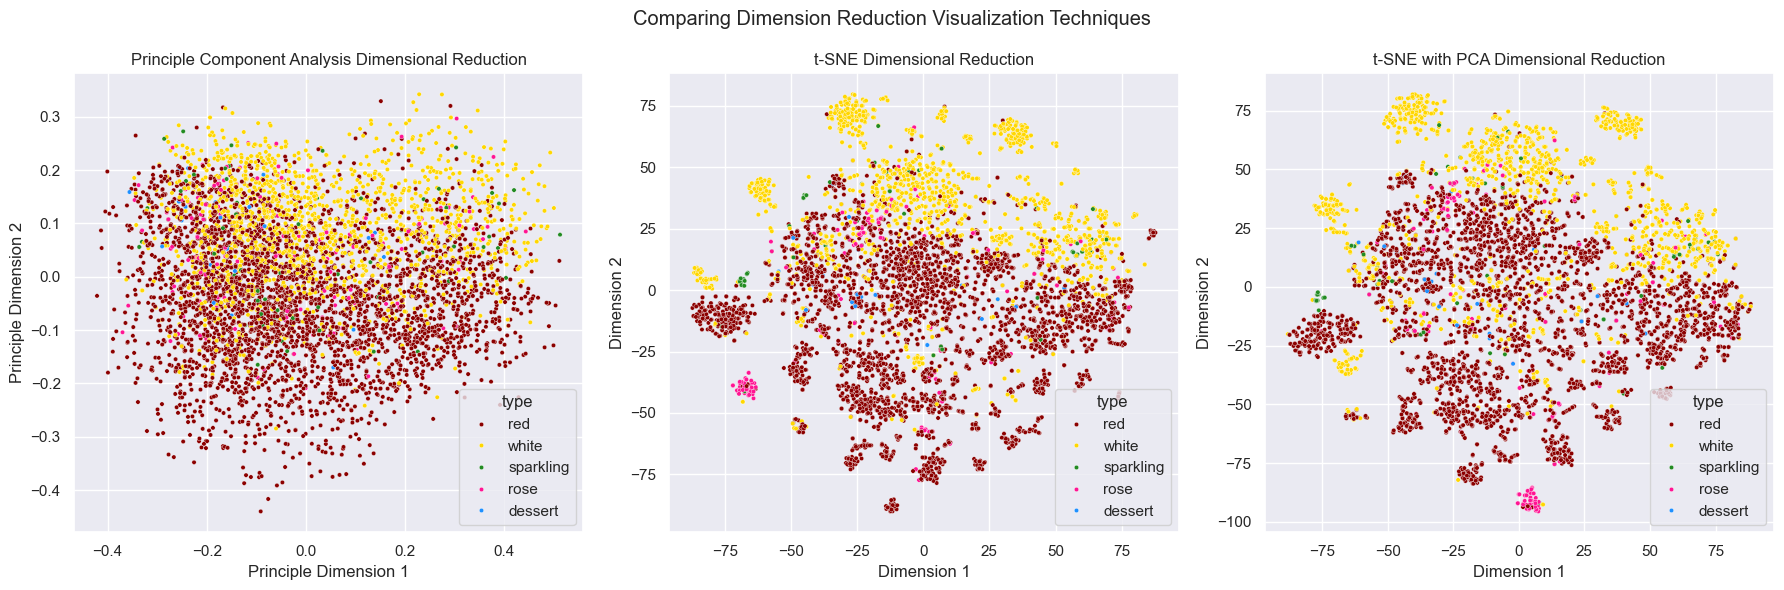

In [20]:
color_map = dict(
  sparkling='forestgreen',
  white='gold',
  rose='deeppink',
  red='darkred',
  dessert='dodgerblue',
)

fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df.loc[s.index].type, ax=ax[0], s=10, palette=color_map)
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=df.loc[s.index].type, ax=ax[1], s=10, palette=color_map)
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.loc[s.index].type, ax=ax[2], s=10, palette=color_map)
plt.suptitle('Comparing Dimension Reduction Visualization Techniques')
ax[0].set_xlabel('Principle Dimension 1')
ax[0].set_ylabel('Principle Dimension 2')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[2].set_xlabel('Dimension 1')
ax[2].set_ylabel('Dimension 2')
ax[0].set_title('Principle Component Analysis Dimensional Reduction')
ax[1].set_title('t-SNE Dimensional Reduction')
ax[2].set_title('t-SNE with PCA Dimensional Reduction')
plt.tight_layout()
plt.show()



**Observation**: The dimensional reduction clearly shows there is some structure to the data

## Cluster Analysis

### KMeans Clustering

see [Clustering documents with TFIDF and KMeans](https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans)

**Pick number of clusters for KMeans**

In [21]:
n_clusters = [len(df.classification.unique()),len(df.type.unique()),len(df.wine_style.unique()),20, 35, len(df.variety.unique())]
n_clusters

[2, 5, 9, 20, 35, 50]

**MiniBatchKMeans**

Using MiniBatchKMeans since there are well over 10k samples.

In [22]:
from sklearn.cluster import MiniBatchKMeans

# sum of squared error vs k
models = [MiniBatchKMeans(n_clusters=n, init_size=1024, batch_size=2048, max_iter=100, random_state=42).fit(X) for n in n_clusters]
models

[MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=2, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=5, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=9, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=20, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=35, random_state=42),
 MiniBatchKMeans(batch_size=2048, init_size=1024, n_clusters=50, random_state=42)]

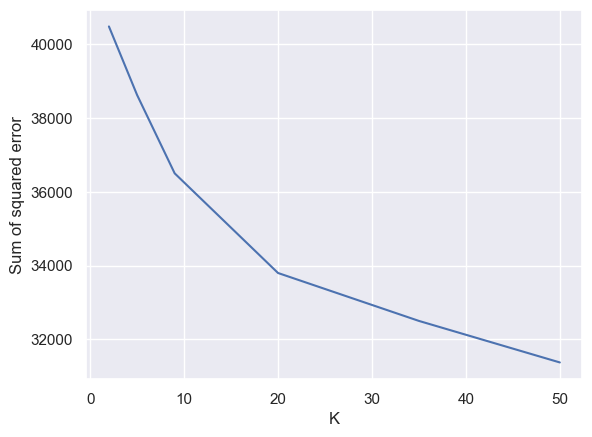

In [23]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(n_clusters,[model.inertia_ for model in models])

**Predict the Wine Cluster Based on Review**

In [24]:
df['predicted_classification'] = models[0].predict(X)
df['predicted_type'] = models[1].predict(X)
df['predicted_wine_style'] = models[2].predict(X)
df['predicted_variety'] = models[5].predict(X)

df.head()

,title,description,variety,country,location,wine_style,type,classification,predicted_classification,predicted_type,predicted_wine_style,predicted_variety
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",White Blend,Italy,Etna,light_white,white,Old World,0,4,2,11
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Portuguese Red,Portugal,Douro,medium_red,red,Old World,1,2,5,27
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Pinot Gris,US,Oregon,light_white,white,New World,0,0,7,24
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Riesling,US,Michigan,aromatic_white,white,New World,0,4,2,7
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Pinot Noir,US,Oregon,light_red,red,New World,1,2,1,36


**Visualize Clusters**

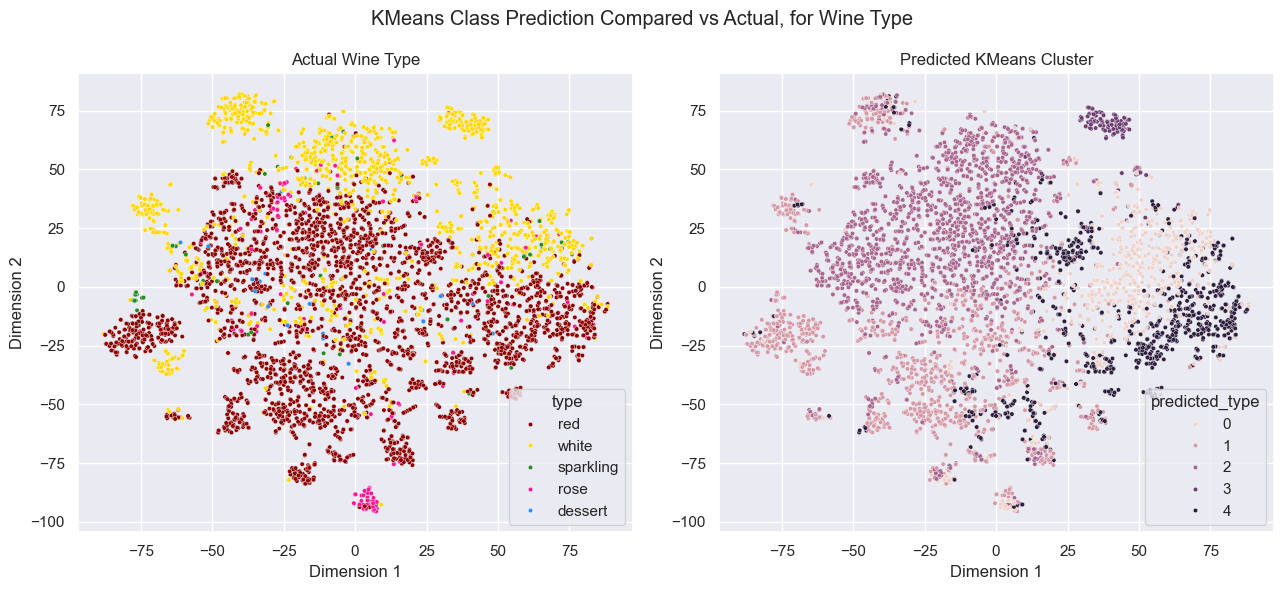

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(13,6))
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.loc[s.index].type, ax=ax[0], s=10, palette=color_map)
sns.scatterplot(x=pca_tsne_result[:,0], y=pca_tsne_result[:,1], hue=df.loc[s.index].predicted_type, ax=ax[1], s=10)
plt.suptitle('KMeans Class Prediction Compared vs Actual, for Wine Type')
ax[0].set_xlabel('Dimension 1')
ax[0].set_ylabel('Dimension 2')
ax[1].set_xlabel('Dimension 1')
ax[1].set_ylabel('Dimension 2')
ax[0].set_title('Actual Wine Type')
ax[1].set_title('Predicted KMeans Cluster')
plt.tight_layout()
plt.show()

### Agglomerative Clustering

 - [Mastering Text Clustering with Python: A Comprehensive Guide](https://medium.com/@mehdirt/mastering-text-clustering-with-python-a-comprehensive-guide-f8617f53c327) Intro to agglomerative clustering
 - [Cosine Similarity and Hierarchical Clustering](https://rafamarino.com/posts/tfidf/#similarity-score--cosine-similarity)
 - [Mastering Hierarchical Clustering : From Basic to Advanced](https://medium.com/@sachinsoni600517/mastering-hierarchical-clustering-from-basic-to-advanced-5e770260bf93)
 - [Plot Hierarchical Clustering Dendrogram](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [29]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [33]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Hierarchical Clustering
# agglo = AgglomerativeClustering(n_clusters=None, metric='cosine', distance_threshold=0, linkage='average', compute_distances=True).fit(PCA(50, random_state=42).fit_transform(s))
agglo = AgglomerativeClustering(n_clusters=None,distance_threshold=0).fit(PCA(50, random_state=42).fit_transform(s))
agglo

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

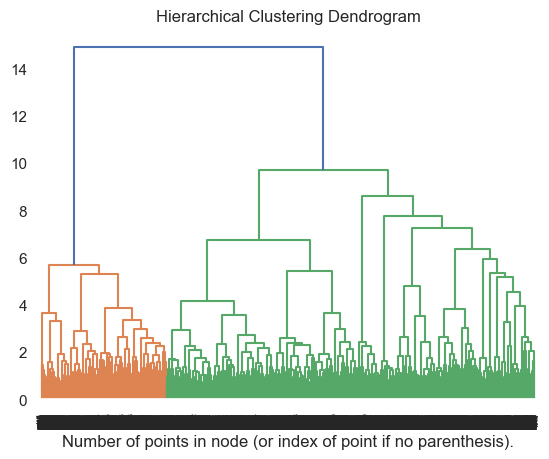

In [34]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Further Work

- Evaluate [silhouette](https://medium.com/@hazallgultekin/what-is-silhouette-score-f428fb39bf9a) scores for clusters.